In [121]:
from pyspark.sql import SparkSession
from pyspark.sql.types import *
import pyspark.sql.functions as func
from pyspark.sql.functions import col
from pyspark.sql import SQLContext
from pyspark import SparkFiles


filename = 'https://stat-ds-test.s3.amazonaws.com/getstat_com_serp_report_201707.csv.gz'

spark = SparkSession \
    .builder \
    .appName("GETSTAT") \
    .getOrCreate()


sqlContext = SQLContext(spark)

spark.sparkContext.addFile(filename)

df = spark.read.csv(SparkFiles.get("getstat_com_serp_report_201707.csv.gz"), header=True)
df = df.withColumnRenamed('Crawl Date', 'Crawl_Date')


"""Parquet file will be written to current directory, it needs to be written to S3"""
df.write.mode('overwrite').parquet("getstat.parquet")
df.head()


Row(Keyword=u'search analytics', Market=u'US-en', Location=None, Device=u'desktop', Crawl_Date=u'2017-07-01', Rank=u'1', URL=u'support.google.com/webmasters/answer/6155685?hl=en')

1. Which URL has the most ranks in the top 10 across all keywords over the period?

In [122]:
#First question
parquetFile = spark.read.parquet("getstat.parquet")
# Create a temporary view and then use SQL statements.
parquetFile.createOrReplaceTempView("tempView")
result = spark.sql("""SELECT URL, sum(case when rank<=10 then 1 else 0 end) as top_sum
                        FROM tempView
                        GROUP BY URL
                        ORDER BY top_sum desc limit 1""")
result.take(1)

[Row(URL=u'serps.com/tools/rank-checker/', top_sum=22982)]

2. Provide the set of keywords (keyword information) where the rank 1 URL changes the most over the period. A change, for the purpose of this question, is when a given keyword's rank 1 URL is different from the previous day's URL.

In [123]:
result = spark.sql("""SELECT keyword,market,location,device,
                    case when URL != (lead(URL,1,null) over(partition by keyword,market,location,device
                       order by crawl_date)) then 1 else 0 end as change_sum
                    FROM tempView
                    WHERE Rank = 1""")
# result.show()

result2 = result.groupBy(['keyword','market','location','device'])\
           .agg(func.sum("change_sum")\
                .alias("change_sum"))\
           .orderBy("change_sum",ascending=False)
result2.show()

+--------------------+------+--------+----------+----------+
|             keyword|market|location|    device|change_sum|
+--------------------+------+--------+----------+----------+
|       google update| GB-en|    null|smartphone|        73|
|       google update| GB-en|    null|   desktop|        44|
|       google update| US-en|    null|smartphone|        43|
|      google updates| GB-en|    null|   desktop|        36|
|seo market & oppo...| US-en|    null|   desktop|        24|
|precise google ra...| US-en|    null|   desktop|        21|
|analytics seo fea...| GB-en|    null|   desktop|        21|
|seo notification ...| GB-en|    null|   desktop|        21|
|seo case studies ...| GB-en|    null|   desktop|        21|
|how much does sta...| CA-en|    null|smartphone|        20|
|          stat local| US-en|    null|   desktop|        20|
|seo tools for dig...| CA-en|    null|smartphone|        20|
|             paa box| CA-en|    null|smartphone|        20|
|       answers boxes| G

3. We would like to understand how similar the results returned for the same keyword, market, and location are across devices. For the set of keywords, markets, and locations that have data for both desktop and smartphone devices, please devise a measure of difference to indicate how similar the URLs and ranks are, and please use this to show how the mobile and desktop results in our provided data set converge or diverge over the period.

A: Saved to result_chart.png


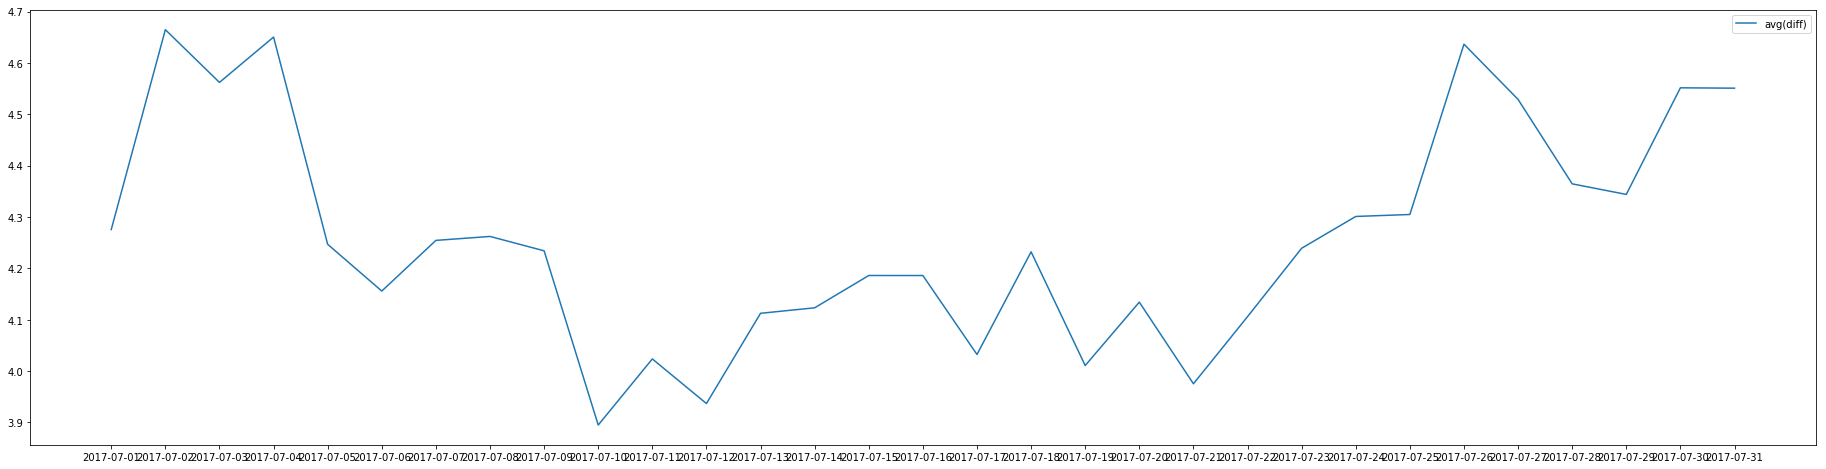

In [136]:
from  pyspark.sql.functions import abs
import matplotlib.pyplot as plt

#dataset that have both desktop and smartphone intersect

result = spark.sql("""select a.* from tempView a
                   inner join 
                   (SELECT keyword,market,location
                             FROM tempView
                             WHERE device = 'desktop'
                             intersect 
                             SELECT keyword,market,location
                             FROM tempView
                             WHERE device = 'smartphone')b
                    on a.keyword = b.keyword and a.market = b.market""")

df_desktop = result.filter(col("device").isin(['desktop']))
df_mobile = result.filter(col("device").isin(['smartphone'])).withColumnRenamed("Rank","Mobile_Rank")

merged_df = df_desktop.join(df_mobile,['Keyword','Market','Crawl_Date','URL'])

# Similarity score, absolute value of difference (diff column).Other similairty score could be used here to more accuracy

merged_df = merged_df.withColumn('diff', abs(merged_df['Rank'] - merged_df['Mobile_Rank']))
merged_df = merged_df.groupBy('Crawl_Date').mean('diff').sort('Crawl_Date')

merged_df = merged_df.toPandas()
x = merged_df['Crawl_Date']
y = merged_df['avg(diff)']
fig = plt.figure(figsize=(32, 8))
plt.plot(x, y)
plt.legend()
fig.savefig('result_chart.png')

